# Notebook 1: Introduction to Alignment

This notebook reviews the classical Needleman–Wunsch algorithm in a form
that matches the notation used in the NW-flex paper. We work with two
sequences
$$
  X = X_1 \dots X_n,\qquad
  Y = Y_1 \dots Y_m,
$$
and a scoring scheme that assigns values to matches, mismatches, and gaps.

## Overview

The global alignment problem is:

> Given sequences $X$ and $Y$, find an alignment (with gap symbols "–")
> that maximizes a prescribed scoring function.

The Needleman–Wunsch algorithm solves this by:

1. Representing prefixes $(X_{1..i}, Y_{1..j})$ as nodes $(i,j)$ in a grid.
2. Defining a recurrence for the optimal score $F(i,j)$ in terms of its
   three predecessors $(i-1,j-1)$, $(i-1,j)$, and $(i,j-1)$.
3. Filling the DP matrix $F$ and tracing back from $(n,m)$ to $(0,0)$
   to recover one optimal alignment.

This notebook is organized as follows:

1. **Sequences and scoring.** Introduce the notation for $X$, $Y$, and the
   match/mismatch/gap scoring scheme.
2. **The alignment DAG.** Represent alignments as paths in a directed
   acyclic graph.
3. **Simple Needleman–Wunsch dynamic program.** Derive and visualize the DP
   recurrence and traceback for linear gaps.
4. **Gotoh: affine gap penalties (short recap).** Introduce the three-state
   DP $(Y_g, M, X_g)$ and the $K_{3,3}$ gadget.

We begin with the simpler case where every gap has a single fixed cost (a linear gap penalty). This lets us focus on the alignment graph and how dynamic programming works step by step. At the end of the notebook, we return to gaps and allow them to be more expensive to start than to extend (often called affine gap penalties). We show how Gotoh’s method handles this by keeping three separate score tables that record whether the alignment currently ends in a match, a gap in the reference, or a gap in the read.


## References

1. Needleman, S. B., & Wunsch, C. D. (1970). A general method applicable to the search for similarities in the amino acid sequence of two proteins. *Journal of Molecular Biology*, 48(3), 443–453. https://doi.org/10.1016/0022-2836(70)90057-4

2. Gotoh, O. (1982). An improved algorithm for matching biological sequences. *Journal of Molecular Biology*, 162(3), 705–708. https://doi.org/10.1016/0022-2836(82)90398-9

3. Pachter, L., & Sturmfels, B. (2005). *Algebraic Statistics for Computational Biology* (pp. 45–90). Cambridge University Press. https://doi.org/10.1017/CBO9780511610684.002

## Setup and imports

In [1]:
# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from nwflex.nw_basics_plot import (
    NWDagPlotter, 
    plot_example_alignments,
    plot_dp_initialization,
    run_dp_fill_demo,
    plot_filled_dag,
    plot_optimal_path
)

from nwflex.nw_basics import nw_gotoh_matrix
from nwflex.plot import (
    draw_affine_k33_dag,
    plot_gotoh_matrices
)

## Sequences and scoring

We start with two short sequences and a simple scoring scheme:

- match = $+5$
- mismatch = $-5$
- gap = $-3$

This keeps the numbers small and makes it easy to follow by hand.

**Note:** If 2*gap > mismatch, the optimal alignments will not use mismatches since they could instead use two gaps.

### Example sequences

In [2]:
X = "GATT"
Y = "GACT"

print("X:", X)
print("Y:", Y)


X: GATT
Y: GACT



### Match, mismatch, and gap penalties


In [3]:

MATCH = 5
MISMATCH = -5
GAP = -3

def pair_score(a: str, b: str) -> int:
    """Return the match/mismatch score for a pair of bases."""
    return MATCH if a == b else MISMATCH

print("MATCH   =", MATCH)
print("MISMATCH=", MISMATCH)
print("GAP     =", GAP)


MATCH   = 5
MISMATCH= -5
GAP     = -3


## The alignment DAG

We view global alignment as finding a path in a directed acyclic graph
(DAG). Let

$$
X = X_1 \dots X_n, \qquad Y = Y_1 \dots Y_m.
$$

We construct a grid of nodes indexed by integer pairs $(i,j)$ with
$0 \le i \le n$ and $0 \le j \le m$, where node $(i,j)$ represents the
prefixes

$$
X_{1..i} = X_1 \dots X_i, \qquad
Y_{1..j} = Y_1 \dots Y_j.
$$


From each node $(i,j)$ we add three types of directed edges:
$$
\begin{aligned}
\textbf{diagonal:}   &\quad (i,j) \to (i+1,j+1)
  && \text{align } X_{i+1} \text{ with } Y_{j+1} && \text{ (match or mismatch)}, \\
\textbf{vertical:}   &\quad (i,j) \to (i+1,j)
  && \text{align } X_{i+1} \text{ with a gap in } Y && \text{ (insertion in } X), \\
\textbf{horizontal:} &\quad (i,j) \to (i,j+1)
  && \text{align a gap in } X \text{ with } Y_{j+1} && \text{ (insertion in } Y).
\end{aligned}
$$

A global alignment corresponds to a path from the source node $(0,0)$ to
the sink node $(n,m)$. 

### Drawing the DAG

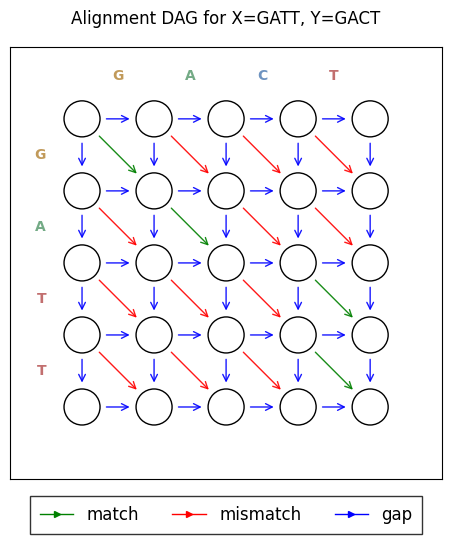

In [4]:
# Create a plotter
plotter = NWDagPlotter(X, Y, match=MATCH, mismatch=MISMATCH, gap=GAP)
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
grid = plotter.draw_grid(ax, edge_alpha=0.9)
fig.suptitle(f"Alignment DAG for X={X}, Y={Y}")

# Add legend with arrows at the bottom
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color='green', lw=1, marker='>', markersize=4, label='match'),
    Line2D([0], [0], color='red', lw=1, marker='>', markersize=4, label='mismatch'),
    Line2D([0], [0], color='blue', lw=1, marker='>', markersize=4, label='gap'),
]
legend = ax.legend(
    handles=legend_handles, 
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.02),
    ncol=3,
    fontsize=12,
    frameon=True,
    edgecolor='black',
    fancybox=False,
    borderpad=0.6,
)
legend.get_frame().set_linewidth(1.0)
plt.tight_layout()
plt.show()

The DAG visually encodes the same three move types: diagonal matches/mismatches,
vertical gaps in $Y$, and horizontal gaps in $X$. The score of a path is the sum of
edge weights.

### Example alignments as paths

Before we introduce the NW algorithm, we first look at a few concrete examples
of alignments and their paths in the DAG. The alignment DAG is built so that
every possible global alignment between $X$ and $Y$ appears as some path from
$(0,0)$ to $(n,m)$. By drawing a few example alignments and then tracing their
paths in the DAG, we make this correspondence explicit: each step in the path
(diagonal, vertical, horizontal) matches exactly one step in the gapped
alignment (match/mismatch, gap in $Y$, gap in $X$).

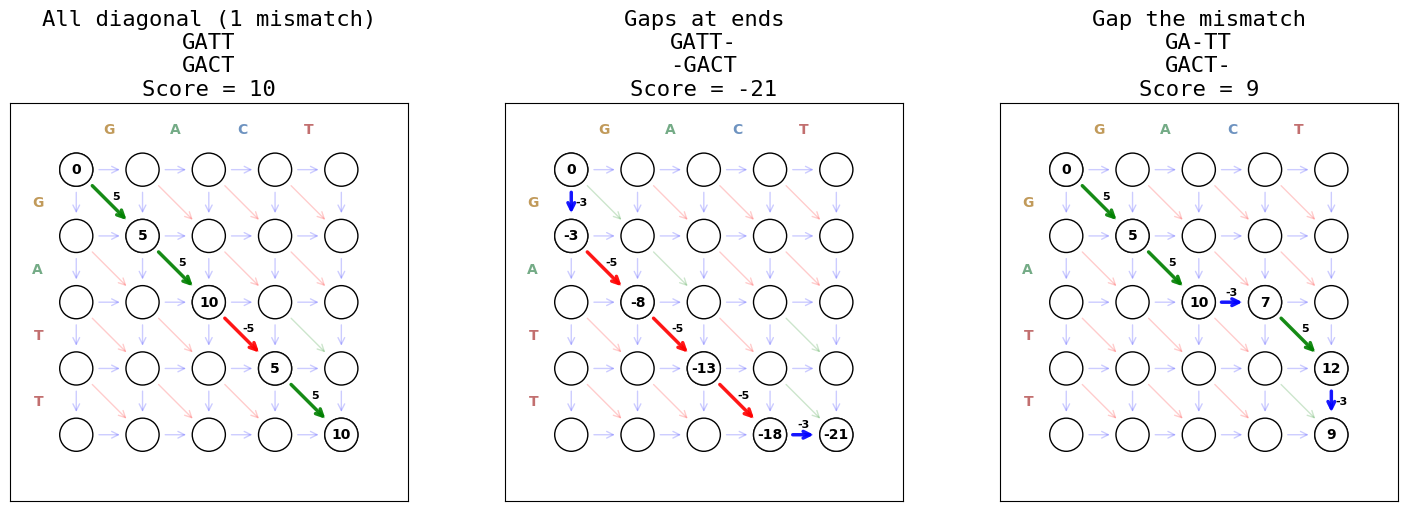

In [5]:
# Define three different paths (alignments) through the DAG
# X = "GATT", Y = "GACT"

# Path 1: All diagonal (direct alignment, one mismatch T vs C)
path1 = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]

# Path 2: Insert gap in Y early, shift alignment
path2 = [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (4, 4)]

# Path 3: Insert gap in X to skip the T-C mismatch
path3 = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 4), (4, 4)]

# Plot all three paths using the helper function
fig, axes = plot_example_alignments(
    X, Y,
    paths=[path1, path2, path3],
    titles=["All diagonal (1 mismatch)", "Gaps at ends", "Gap the mismatch"],
    match=MATCH, mismatch=MISMATCH, gap=GAP,
)

The figure above shows three different paths through the DAG, each
corresponding to a different alignment of $X = \texttt{GATT}$ and $Y = \texttt{GACT}$:

- **Left panel (score=10)**: All diagonal moves. This aligns every position
  directly: G–G (match, +5), A–A (match, +5), T–C (mismatch, -5), T–T (match, +5).
  Total: $5 + 5 - 5 + 5 = 10$.

- **Center panel (score=-21)**: This path takes a vertical move first (gap in Y),
  then proceeds diagonally before a final horizontal move. The shifted alignment
  causes more mismatches and gaps, resulting in a poor score.

- **Right panel (score=9)**: This path inserts a gap in X (horizontal move) to
  skip the C in Y, avoiding the T–C mismatch. The alignment is GA-TT / GACT-
  with score $5 + 5 - 3 + 5 - 3 = 9$.

Next, we will see how the Needleman–Wunsch algorithm systematically identifies the best path 
by computing optimal scores for all prefix pairs $(X_{1..i}, Y_{1..j})$ using dynamic programming.

## Simple Needleman–Wunsch dynamic program

We now implement a basic global alignment DP with a single penalty per gap.

Let $F(i,j)$ denote the best score for aligning
$X_{1..i}$ with $Y_{1..j}$. The recurrence is

$$
F(i,j) = \max \Big\{
  F(i-1,j-1) + s(X_i, Y_j),\;
  F(i-1,j)   + \text{gap},\;
  F(i,j-1)   + \text{gap}
\Big\},
$$

where

- $s(X_i, Y_j)$ is the match/mismatch score for aligning $X_i$ with $Y_j$,
- `gap` is the penalty for inserting a gap in either sequence.

### Initialization (boundary conditions)

Before filling interior cells, we must initialize the boundaries:

$$
F(0,0) = 0
$$

$$
F(i,0) = i \cdot \text{gap}
\quad\text{for } 1 \le i \le n,
$$

$$
F(0,j) = j \cdot \text{gap}
\quad\text{for } 1 \le j \le m.
$$

These correspond to aligning a prefix of one sequence against an all-gap
prefix of the other, with each gap incurring the same cost.


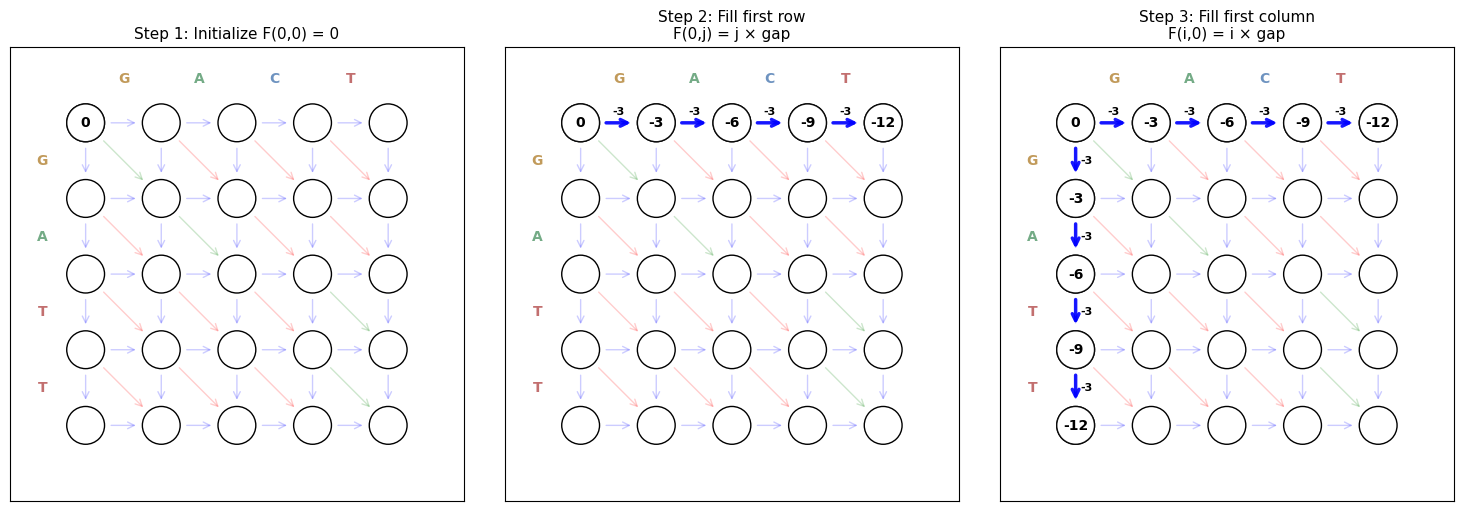

In [6]:
# Visualize the initialization steps
fig_init, axes = plot_dp_initialization(X, Y, match=MATCH, mismatch=MISMATCH, gap=GAP)

The figure above shows how we initialize the first row and column of the DAG. 
Once these boundary cases are filled in, every interior node has exactly three possible incoming edges, 
so the same update rule applies uniformly to all remaining entries.
With boundaries initialized, we can now fill the interior cells using the recurrence.

### Filling an interior cell

We compare the three possible ways to reach $(1,1)$:

$$
\begin{aligned}
\textbf{from left:}     &\quad (1,0) \to (1,1)  && F(1,0) + \text{gap}  &&= -3 + (-3) &&= -6 && \text{gap } Y: (\texttt{G}, \texttt{-}), \\
\textbf{from diagonal:} &\quad (0,0) \to (1,1)  && F(0,0) + s(X_1, Y_1) &&= 0 + 5     &&= +5 && \text{match} : (\texttt{G}, \texttt{G}), \\
\textbf{from above:}    &\quad (0,1) \to (1,1)  && F(0,1) + \text{gap}  &&= -3 + (-3) &&= -6 && \text{gap } X: (\texttt{-}, \texttt{G}).
\end{aligned}
$$

By definition, $F(i,j)$ is the best score over all paths from $(0,0)$ to $(i,j)$. Any such path must arrive at
$(i,j)$ from one of its three predecessors, so its score can be no better than the best of these three candidate
scores. Taking the maximum of the three therefore enforces the “best over all paths” definition of $F(i,j)$.

The maximum is $5$ (diagonal), so $F(1,1) = 5$.

The function `run_dp_fill_demo` wraps this logic for all cells: it iterates over the
DP grid, computes the three candidates at each $(i,j)$, writes the best score
into `F[i, j]`, records which move was chosen, and produces the panel-style
visualization.

**Note:** Change `show_first_n` and `show_last_m` in the call to `run_dp_fill_demo`
to visualize different portions of the DP fill.


DP fill: visualizing first 2 and last 2 of 16 interior cells



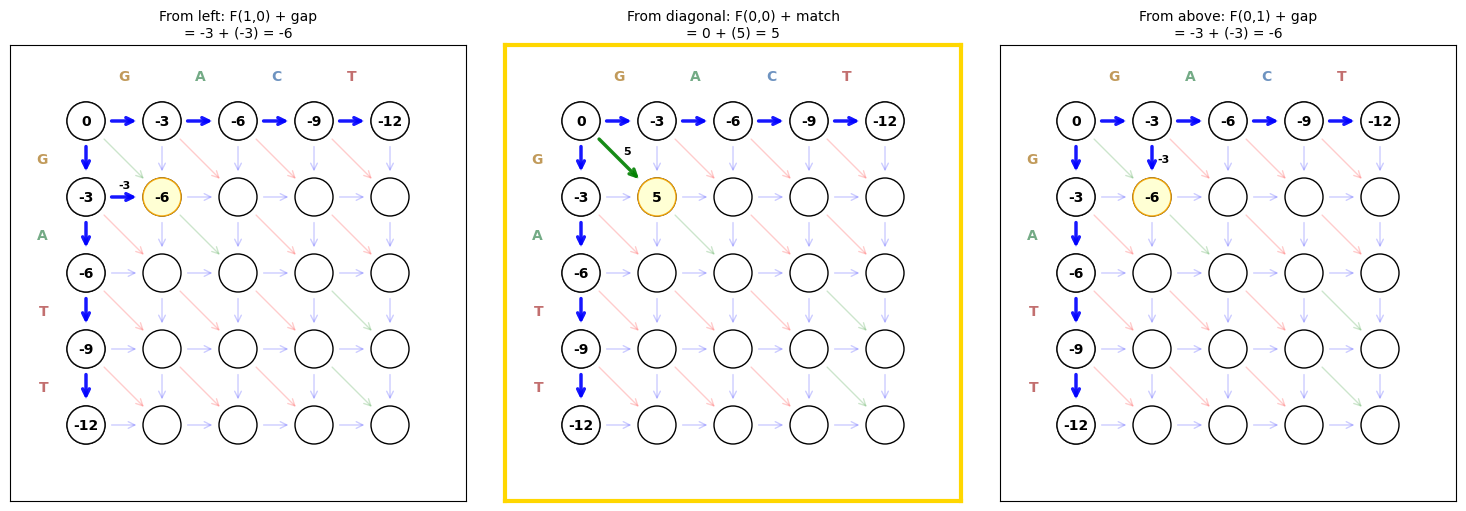

Cell (1, 1): best_move='diag', best_score=5



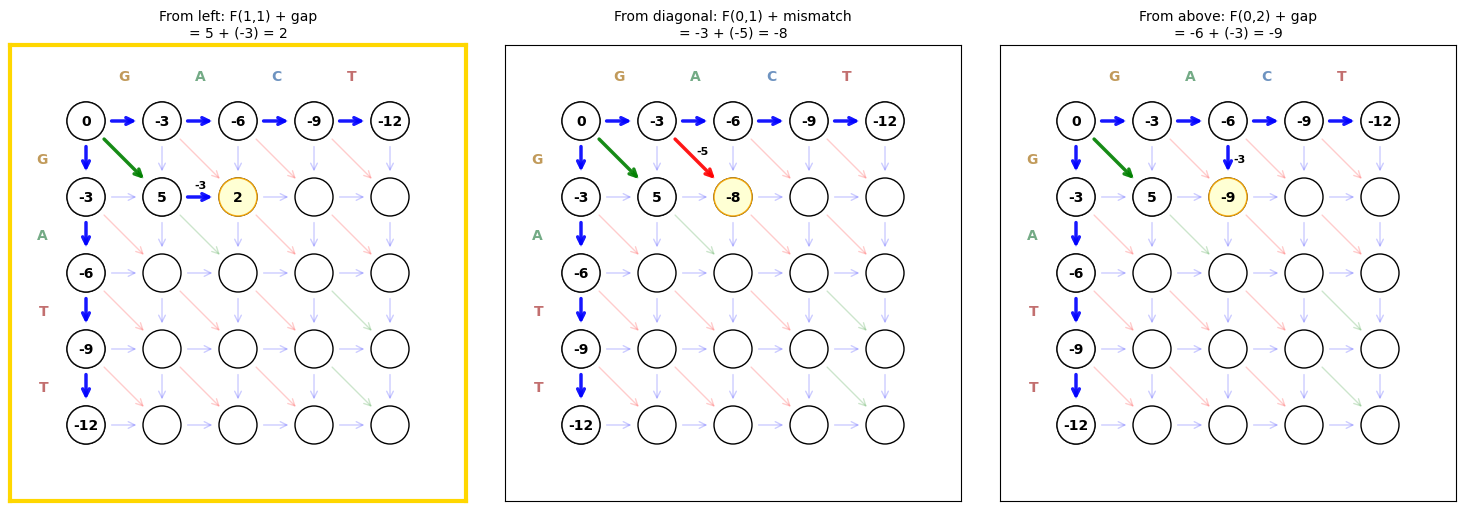

Cell (1, 2): best_move='left', best_score=2

... (silently filling 12 intermediate cells) ...



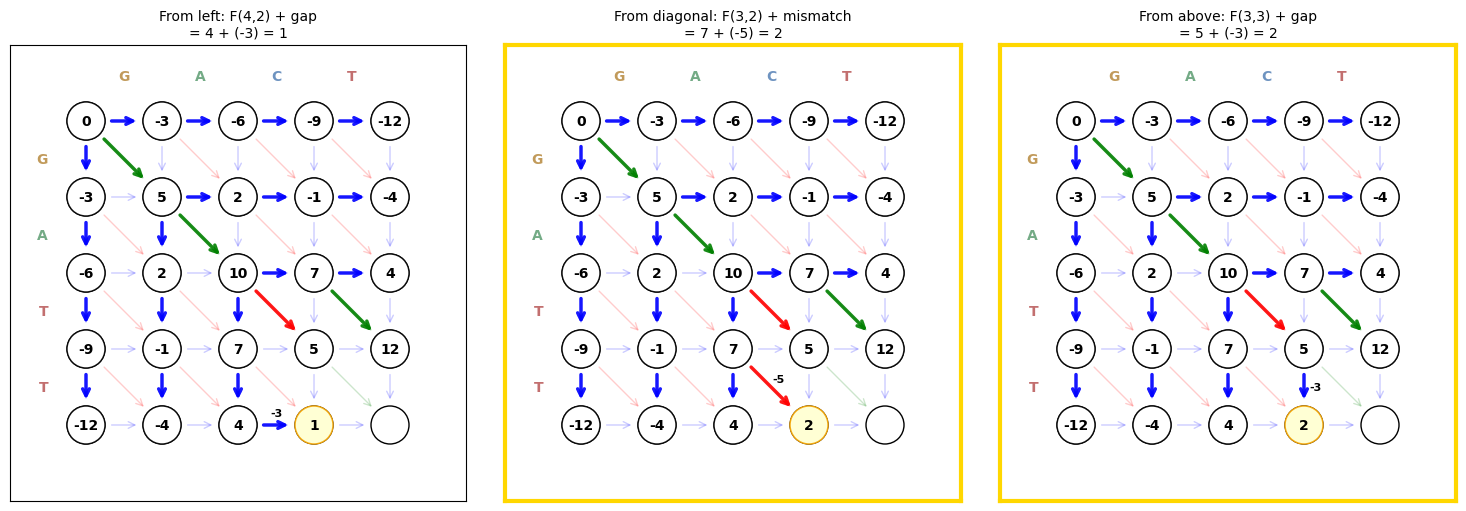

Cell (4, 3): best_move='diag', best_score=2



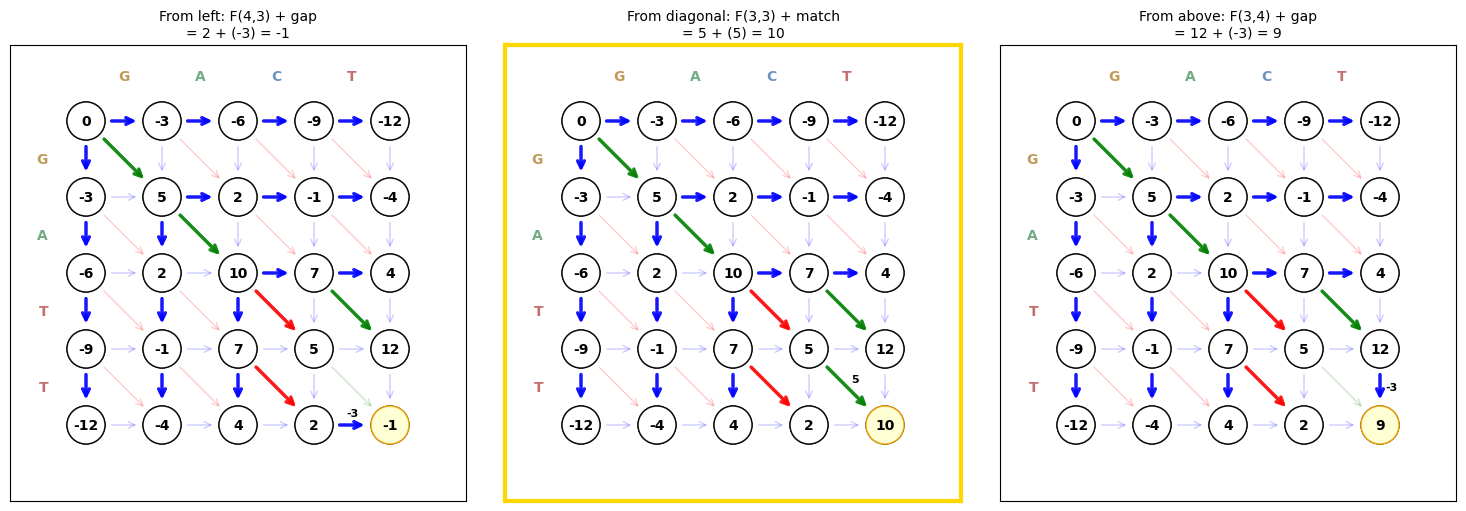

Cell (4, 4): best_move='diag', best_score=10

*** Final alignment score: F[4,4] = 10 ***


In [7]:
# Run and visualize the DP fill process
dp_result = run_dp_fill_demo(X, Y, match=MATCH, mismatch=MISMATCH, gap=GAP,
                              show_first_n=2, show_last_m=2)

### Multiple optimal paths

Sometimes more than one incoming edge gives the same best score at a cell.
In the panel above, cell $(4,3)$ can be reached with score $2$ both from the diagonal and from above. 
The DP table only needs the *value* of $F(i,j)$, so ties do not change the scores; they only affect which path we recover during traceback.
In this demo we record a single predecessor at each cell, so the visualization shows one optimal path, not all of them. 
A different tie-breaking rule would produce a different, but equally good, optimal alignment.

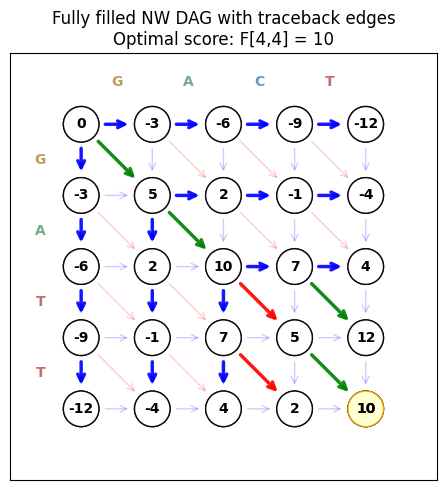


Final F matrix:
[[  0  -3  -6  -9 -12]
 [ -3   5   2  -1  -4]
 [ -6   2  10   7   4]
 [ -9  -1   7   5  12]
 [-12  -4   4   2  10]]


In [8]:
# Plot the fully filled DAG with all traceback edges
fig, ax = plot_filled_dag(
    X, Y, dp_result['F'], dp_result['traceback_edges'],
    match=MATCH, mismatch=MISMATCH, gap=GAP,
    plotter=dp_result['plotter'], figsize=(6, 5)
)

### Traceback: recovering the optimal alignment

The traceback edges recorded during the DP fill represent a best 
predecessors for each cell. To find *one* optimal alignment, we trace back 
from $(n,m)$ to $(0,0)$ following these edges. This gives us a single path 
through the DAG corresponding to one optimal alignment.

The figure below highlights this **optimal path** in red, showing the 
exact sequence of moves that yields the best alignment score.

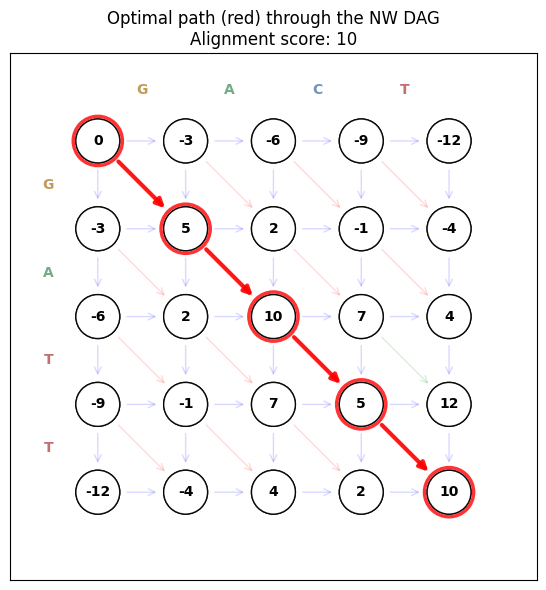

Optimal alignment recovered from traceback:
  X: GATT
  Y: GACT
     ||x|
     (|=match, x=mismatch, space=gap)


In [9]:
# Plot the optimal path and recover the alignment
fig, ax, alignment_info = plot_optimal_path(
    X, Y, dp_result['F'], dp_result['traceback_edges'],
    match=MATCH, mismatch=MISMATCH, gap=GAP,
    plotter=dp_result['plotter']
)

## Gotoh: NW with affine gap penalties 

So far we used a single DP matrix $F$ with a **linear gap penalty**, where
each gap character costs the same amount. This means ten separate 1-bp gaps
have the same total cost as one 10-bp deletion, even though in real
sequences long contiguous insertions/deletions are common while starting a
new gap is rarer. To reflect this, it is more realistic to use an **affine
gap penalty**, which makes opening a gap expensive but extending an existing
gap cheaper.

Gotoh's affine-gap formulation keeps the global-alignment setup but tracks
three DP layers at each cell $(i,j)$:

- $Y_g(i,j)$: best score ending with a gap in $X$ (horizontal move),
- $M(i,j)$: best score ending with a match or mismatch (diagonal move),
- $X_g(i,j)$: best score ending with a gap in $Y$ (vertical move).

In this section we will:

1. run the Gotoh algorithm on an example pair of sequences,
2. briefly explain why these three layers are needed for affine gaps, and
3. summarize the three-state recurrences and their $K_{3,3}$ gadget view.


### Example sequences

For the affine-gap example we use longer sequences that will reappear in 
the next NW-flex notebook:

- $X = \texttt{GATTACA}$
- $Y = \texttt{GTTCA}$


In [10]:
# Example sequences for affine-gap (Gotoh) alignment
X = "GATTACA"
Y = "GTTCA"

print("Affine-gap example:")
print("X:", X)
print("Y:", Y)


Affine-gap example:
X: GATTACA
Y: GTTCA



### Scoring and affine gap penalty

For this affine-gap example we use the same basic scoring scheme as in the
NW-flex notebooks:

- match: $+5$
- mismatch: $-5$
- gap start $g_s$: $-20$
- gap extend $g_e$: $-1$

A contiguous gap of length $k$ then has total cost
$$
\text{gap\_cost}(k) = g_s + (k-1) g_e.
$$

These values make a single long gap cheaper (per base) than breaking it into
many short gaps, mirroring the idea that one long indel event is more likely
than many independent small ones.

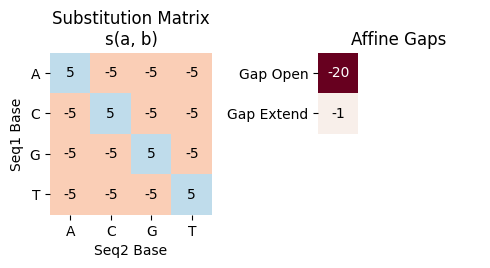

In [11]:
# Scoring scheme
from nwflex.validation import get_default_scoring
from nwflex.plot import plot_score_system


score_matrix, gap_open, gap_extend, alphabet_to_index = get_default_scoring()

# Display the default score scheme:
clean_map = {str(k): v for k, v in alphabet_to_index.items()}
fig = plot_score_system(
    score_matrix, gap_open, gap_extend, alphabet_to_index,
    figsize=(5, 3.5)
)
plt.show()

### Why affine gaps require three layers

In the linear-gap DP above, each horizontal or vertical move adds the
same gap cost, so a single matrix $F(i,j)$ is enough.

With an affine penalty
$$
\text{gap\_cost}(k) = g_s + (k-1) g_e,
$$
we must distinguish between opening a gap (pay $g_s$) and extending an
existing gap (pay $g_e$). To decide which cost applies at $(i,j)$ we need
to know whether the previous step already had a gap or not, which a single
value $F(i,j)$ does not record.

Gotoh's idea is to keep three scores at each cell $(i,j)$, one for each
possible last move:

| State | Meaning                      | Last move type   |
|:-----:|:-----------------------------|:-----------------|
| $Y_g$ | gap in $X$ (horizontal move) | horizontal       |
| $M$   | match/mismatch (diagonal)    | diagonal         |
| $X_g$ | gap in $Y$ (vertical move)   | vertical         |

This three-layer view makes the affine-gap bookkeeping local: each state
only looks at the appropriate predecessors from the previous row/column.



### Gotoh recurrences

Let $\sigma(a,b)$ be the substitution score for aligning $a$ with $b$, and let
$g_s$ and $g_e$ be the gap-start and gap-extend penalties.

For global alignment we first set the boundary conditions:
$$
M(0,0) = 0, \qquad Y_g(0,0) = X_g(0,0) = -\infty,
$$
$$
Y_g(0,j) = g_s + (j-1)\,g_e \quad \text{for } j \ge 1,
$$
$$
X_g(i,0) = g_s + (i-1)\,g_e \quad \text{for } i \ge 1,
$$
and all other entries with $i = 0$ or $j = 0$ are set to $-\infty$.

For $1 \le i \le n$ and $1 \le j \le m$ the three-layer DP updates are
$$
Y_g(i,j) = \max \big\{
  Y_g(i,j-1) + g_e,\,
  M(i,j-1)   + g_s,\,
  X_g(i,j-1) + g_s
\big\},
$$
$$
M(i,j) = \sigma(X_i, Y_j) + \max \big\{
  Y_g(i-1,j-1),\,
  M(i-1,j-1),\,
  X_g(i-1,j-1)
\big\},
$$
$$
X_g(i,j) = \max \big\{
  X_g(i-1,j) + g_e,\,
  M(i-1,j)   + g_s,\,
  Y_g(i-1,j) + g_s
\big\}.
$$

Here $Y_g(i,j)$, $M(i,j)$, and $X_g(i,j)$ are exactly the “last-move” scores
described above: best scores ending with a gap in $X$, a match/mismatch, or a
gap in $Y$, respectively. The final global-alignment score is
$$
\text{score} = \max \big\{ Y_g(n,m),\, M(n,m),\, X_g(n,m) \big\}.
$$


Gotoh alignment score: -6.0

Optimal alignment (affine gaps):
X: GATTACA
Y: G--TTCA
   |  |x||


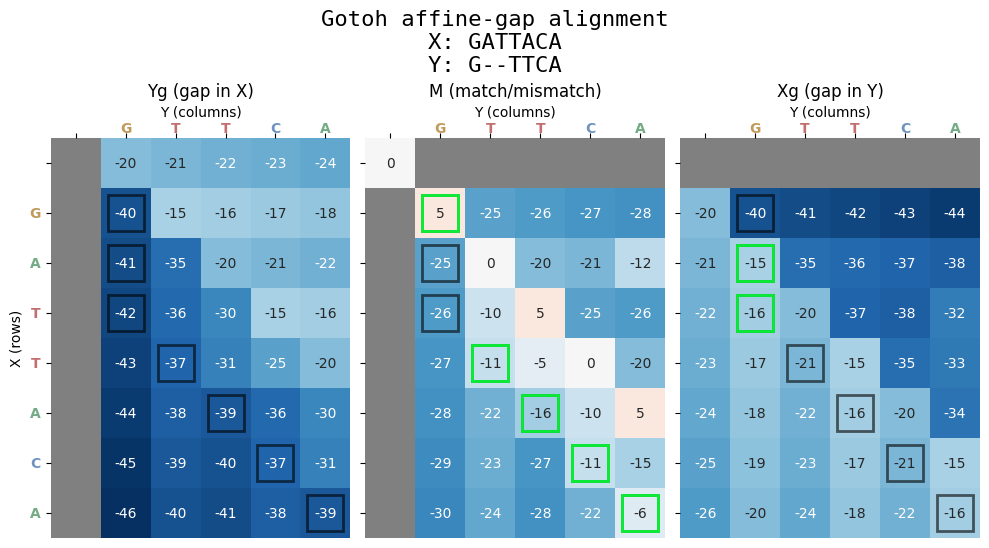

In [12]:
# Run Gotoh affine-gap alignment
gotoh_result = nw_gotoh_matrix(
    seq1=X,
    seq2=Y,
    alphabet_to_index=alphabet_to_index,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    return_matrices=True,
)

print("Gotoh alignment score:", gotoh_result.total_score)
print()
print("Optimal alignment (affine gaps):")
print("X:", gotoh_result.seq_align1)
print("Y:", gotoh_result.seq_align2)

# Simple match / mismatch / gap pattern for the alignment:
match_line = "".join(
    "|" if a == b else " " if a == "-" or b == "-" else "x"
    for a, b in zip(gotoh_result.seq_align1, gotoh_result.seq_align2)
)
print("   " + match_line)

# Visualize the three Gotoh layers (Yg, M, Xg) with traceback path
fig_gotoh = plot_gotoh_matrices(
    gotoh_result,
    X=X,
    Y=Y,
    figsize=(10, 6),
    marker_size=26,
)

title = (
    "Gotoh affine-gap alignment\n"
    f"X: {gotoh_result.seq_align1}\n"
    f"Y: {gotoh_result.seq_align2}"
)
fig_gotoh.suptitle(title, fontsize=16, font='monospace')
fig_gotoh.tight_layout()
plt.show()


### Reading the Gotoh DP figure

The figure above shows the three dynamic-programming layers used by Gotoh’s
affine-gap algorithm:

- **Left panel (Yg)**: best scores for paths that end in a gap in $X$
  (horizontal move).
- **Middle panel (M)**: best scores for paths that end in a match or mismatch
  (diagonal move).
- **Right panel (Xg)**: best scores for paths that end in a gap in $Y$
  (vertical move).

Each cell shows the score for that state at position $(i,j)$, with color
indicating how favorable it is (red good; blue bad). The squares trace one
optimal alignment path: for each $(i,j)$ on the path we draw a faint marker
on all three panels and a bright marker on the panel whose state is active
there. As you follow the markers across panels, you can see when the
alignment switches between “in a gap in $X$”, “in a match/mismatch”, and
“in a gap in $Y$” to realize the affine gap penalties.


### Gotoh recurrences

Let $\sigma(a,b)$ be the substitution score for aligning $a$ with $b$, 
and let $g_s$ and $g_e$ be the gap-start and gap-extend penalties.

For $1 \le i \le n$ and $1 \le j \le m$ the three-layer DP updates are
$$
\begin{aligned}
\textbf{Y-layer:} &&\quad
Y_g(i,j) &= &&\max \Big\{
  Y_g(i,j-1) + g_e,\;
  M(i,j-1)   + g_s,\;
  X_g(i,j-1) + g_s
\Big\}, \\
\textbf{M-layer:} &&\quad
M(i,j)   &=\quad\sigma(X_i, Y_j)\quad+ &&\max \Big\{
  Y_g(i-1,j-1),\;
  M(i-1,j-1),\;
  X_g(i-1,j-1)
\Big\}, \\
\textbf{X-layer:} &&\quad
X_g(i,j) &= &&\max \Big\{
  X_g(i-1,j) + g_e,\;
  M(i-1,j)   + g_s,\;
  Y_g(i-1,j) + g_s
\Big\}.
\end{aligned}
$$

Here $Y_g(i,j)$, $M(i,j)$, and $X_g(i,j)$ are exactly the “last-move”
scores introduced above: best scores ending with a gap in $X$, a
match/mismatch, or a gap in $Y$, respectively.

The final global-alignment score is
$$
\text{score} = \max \big\{ Y_g(n,m),\, M(n,m),\, X_g(n,m) \big\}.
$$

For global alignment, we initialize
$$
M(0,0) = 0, \qquad Y_g(0,0) = X_g(0,0) = -\infty,
$$
$$
Y_g(0,j) = g_s + (j-1)\,g_e \quad \text{for } j \ge 1,
$$
$$
X_g(i,0) = g_s + (i-1)\,g_e \quad \text{for } i \ge 1,
$$
and set all other entries with $i = 0$ or $j = 0$ to $-\infty$.


### The $K_{3,3}$ gadget view

A helpful way to picture Gotoh’s three-layer DP, adapted from a diagram in
*Algebraic Statistics for Computational Biology* (Pachter and Sturmfels, eds.),
is to treat each cell $(i,j)$ as a small $K_{3,3}$-style gadget with six ports:
three incoming ($H_{in}$, $D_{in}$, $V_{in}$) and three outgoing
($H_{out}$, $D_{out}$, $V_{out}$). The internal wiring within each gadget
encodes the gap-open vs gap-extend logic.

The figure below shows this structure for a small alignment grid:

- **Green** diagonal edges: match (positive substitution score)
- **Red** diagonal edges: mismatch (negative substitution score)
- **Blue** horizontal/vertical edges: gap-extend penalty $g_e$
- **Orange** internal edges: gap-initiate penalty $(g_s - g_e)$
- **Gray** internal edges: zero-cost transitions (e.g., any state $\to$ diagonal out)


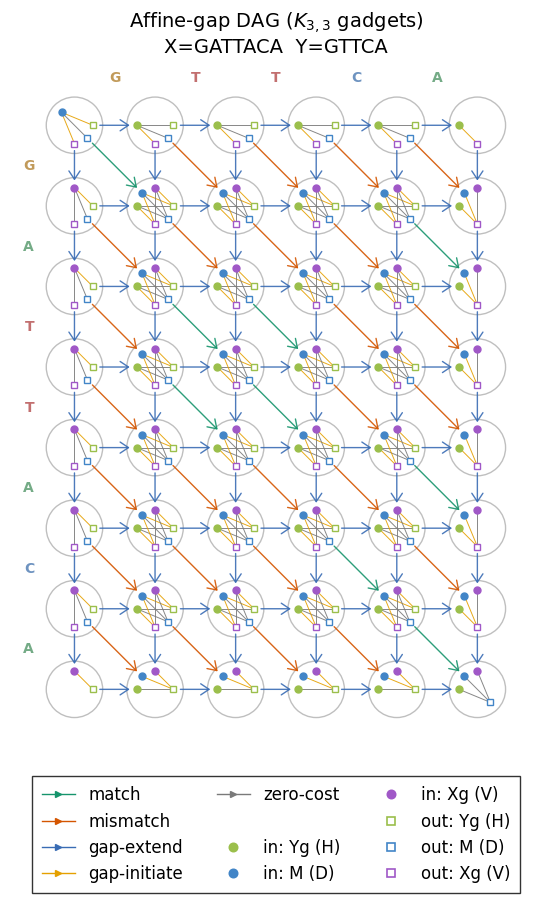

In [13]:
# Draw the K₃,₃ gadget DAG for the example sequences
fig_k33 = draw_affine_k33_dag(
    X,
    Y,
    match=MATCH,
    mismatch=MISMATCH,
    figsize=(8, 9),
)

##  From Gotoh to NW-flex

The NW-flex algorithm builds directly on this three-state Gotoh view:

- It keeps the same scoring scheme (match, mismatch, affine gaps).
- It augments the DP graph with **extra predecessor** (**EP**) sets $E(i)$ for
  selected rows $i$, which can be viewed as adding additional edges
  between rows in the DAG.
- This lets a designated block $Z$ "flex" (for example, an STR region),
  while the flanking regions $A$ and $B$ remain globally aligned.

The next notebook, *NW-flex single-block*, will use the full NW-flex
core (`dp_core`, `ep_patterns`, `aligners`) together with our DP
plotting helpers to show how the sets $E(i)$ modify the DP grid and how
row jumps encode flexible substrings $Z^*$ in an $A \cdot Z^* \cdot B$
reference.

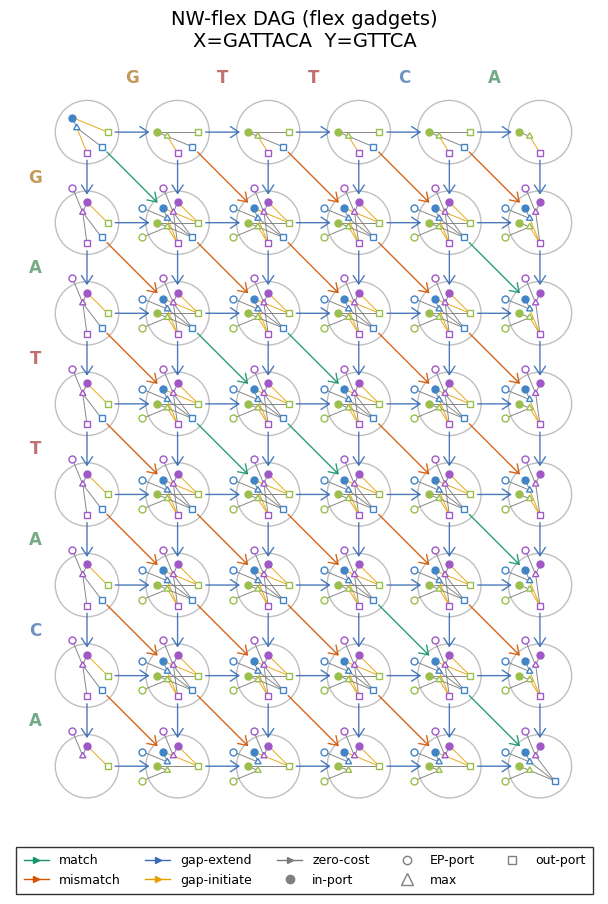

In [14]:
from nwflex.plot import draw_flex_dag

ans = draw_flex_dag(
        seq1= X,
        seq2= Y,
        match= 5,
        mismatch= -5,
        spacing= 1.0,
        gadget_radius= 0.35,
        inner_radius_scale= 0.65,
        max_radius_scale= 0.35,
        port_marker_size= 5.0,
        max_marker_size= 0.04,
        ep_marker_size= 4.0,
        ep_radius_scale= 1.2,
        circle_alpha= 0.5,
        circle_linewidth= 1.0,
        edge_linewidth= 1.0,
        edge_alpha= 0.9,
        lw_internal= 0.7,
        internal_alpha= 0.9,
        mutation_scale= 10.0,
        edge_shrink_factor= 0.15,
        show_legend= True,
        show_internal= True,
        figsize= (9, 10),
        title= None,
        nt_color_map= None,
    )